# 05 - Redditor Expertise Matching 

This notebook tests the scheme for finding the best redditor to address a user question.  

The user question is transformed via Truncated SVD.  This vector is then compared to the SVD-transformed total corpus of each 'prolific' redditor in r/askscience (40+ comments).  The redditor whose transformed corpus yields the best cosine similarity is returned.

Next, the notebook transforms the individual comments for this redditor using the same SVD and returns the comment with maximial cosine similarity to the user question.

In [1]:
import pandas as pd
import pymongo
import string
import numpy as np
import os
import pickle
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
from sklearn.metrics import pairwise
import re
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

bp_pickles = '/home/ubuntu/proj_asksci/files_out/pickles'

### Functions to clean up the redditor text (same code used in processing abstracts)

In [2]:
def separate_sentences (s):
    s = re.sub('\.[a-zA-z]', lambda x: x.group(0)[0:-1] + ' ' + x.group(0)[-1], s)
    return s

def clean_text (s):
    try:
        s = filter (lambda x: x in string.printable, s) # Remove unprintable weirdness. NO ERR
        s = s.strip() #NO ERR
        s = separate_sentences (s)
    except:
        print '******* ERR'
    return s

### Function to SVD-transform and topic-classify user question

In [3]:
def transform_classify_text (t, vectorizer_obj, dimreduce_obj, classifier_obj = None):
    t_vec   = vectorizer_obj.transform(t)
    t_xform = dimreduce_obj.transform(t_vec)
    if not classifier_obj == None:
        topic = classifier_obj.predict (t_xform)
    else: 
        topic = None
    return t_xform, topic

### Function to Build dataframe mapping redditor to cosine similarity with the question

In [4]:
def build_cosine_sim_df (df_reddit, q_xform):

    # Build a new 2-column dataframe, with AUTHORS and cosine similarity to question
    df_cossim = pd.DataFrame()
    df_cossim['AUTHOR']   = df_reddit.AUTHOR
    
    # Extract the SVD values from the redditor dataframe, to yield an N_redditor x 200
    # numpy array.
    SVD_array = np.array ([df_reddit.iloc[i].SVD for i in range (len (df_reddit))])
    
    cs = pairwise.cosine_similarity (q_xform, SVD_array).transpose()
    df_cossim['COS_SIM']  = cs.tolist() 
    df_cossim = df_cossim.sort_values (['COS_SIM'], ascending=False)
    return df_cossim
    

### Function to Build dataframe mapping individual reddit comment to cosine similarity with question

In [5]:
# Function ingests the SVD-transformed user question, along with the redditor info dataframe 
# that contains the SVD-transformed representation of each redditors total corpus.
#
# Then build a new dataframe giving cosine similarity between the question and each
# redditor's corpus.

def build_cosine_sim_comment_df (comments_list, q_xform):
    # Build a new 2-column dataframe, with comment and cosine similarity to question
    df_cossim = pd.DataFrame()
    df_cossim['COMMENT'] = comments_list
    
    comments_xform, topic_dummy = transform_classify_text (comments_list,\
                                             TFIDF_obj, SVD_obj, \
                                             classifier_obj = None)
    
    cs = pairwise.cosine_similarity (q_xform, comments_xform).transpose()
    df_cossim['COS_SIM'] = cs.tolist()
    df_cossim = df_cossim.sort_values (['COS_SIM'], ascending = False)
    return df_cossim

### Function to find best-matched redditor and comment for user question
If verbose argument == True, the results will be printed to notebook

In [6]:
def process_user_question (q, df_reddit, dict_reddit, TFIDF_obj, SVD_obj, \
                       classifier_obj, verbose = True):
    
    # transform and classify the question
    q_xform, q_topic = transform_classify_text (np.array([q]), TFIDF_obj, \
                                                SVD_obj, classifier_obj)
    
    q_topic = q_topic [0][0:-4]  #Remove '_ALL' tag at end of topic label.
    
    # Build dataframe mapping authors to their 'total comment corpus'
    # cosine similarity to the question asked.
    df_cossim = build_cosine_sim_df (df_reddit, q_xform)

    #Get the author at the top of the dataframe (best cosine similarity)
    u = str (df_cossim.AUTHOR.tolist()[0])
    url = 'reddit.com/u/' + u  # Url to view all comments from given user
    
    # From the comments dictionary, transfrom the individual comments for best redditor
    comments_list = [dict_reddit[u][i]['BODY'] for i in range (len(dict_reddit[u]))]

    
    # Compute cosine similarity of each comment to the question
    df_cossim_com = build_cosine_sim_comment_df (comments_list, q_xform) 
    
    # Extract the top comment (best cosine similarity) from the df
    comment_match = df_cossim_com.COMMENT.tolist()[0]
    
    n = len (comments_list) #Number of comments for best-matched redditor
    
    if verbose == True:
        print 'THIS IS A QUESTION ABOUT ' + q_topic
        print 'BEST REDDITOR MATCH IS ' + u
        print 'URL FOR REDDITOR IS ' + url
        print 'THIS USER HAS ' + str (n) + ' COMMENTS IN /r/askscience' 
        print
        print 'COMMENT BEST MATCHING QUESTION IS... '
        print 
        print comment_match
    
    #DBG
    #for i in range (len (df_cossim_com)):
    #    print df_cossim_com.COMMENT.iloc[i]
    #    print df_cossim_com.COS_SIM.iloc[i]
    
    return q_topic, u, comment_match, n, url

# MAIN
First load the pickled objects

In [7]:
# Load the dataframe with the consolidated redditor info.
# This object includes the SVD representation of the redditor's
# entire comment corpus

with open (os.path.join (bp_pickles, 'df_redditors.pkl')) as f:
    df_reddit = %time pickle.load (f)  # 4 sec

# Open the dictionary of redditors.  They keys are authors,
# and the values are LISTS of DICTIONARIES, each of which correspond
# to one comment.  This allows matching on individual comments.
# NOTE -- this dictionary is limited to 'prolific redditors' with 40+ comments.
with open (os.path.join (bp_pickles, 'prolific_ask_reddit_archive.pkl')) as f:
    dict_reddit = %time pickle.load (f)
    
with open (os.path.join (bp_pickles, 'tfidf_obj.pkl')) as f:
    TFIDF_obj = %time pickle.load (f) # 6 sec
    
# Load the SVD transformer (200-SVC) and the trained 200-comp SVC classifier
with open (os.path.join (bp_pickles, 'TruncSVD_200_comp.pkl')) as f:
    SVD_obj = %time pickle.load (f) # 12 sec
    
# Load the trained Support Vector Classifier
with open (os.path.join (bp_pickles, 'app_SVC.pkl')) as f:
    classifier_obj = %time pickle.load (f) # 3.16 ms
    


CPU times: user 232 ms, sys: 12 ms, total: 244 ms
Wall time: 246 ms
CPU times: user 10.1 s, sys: 580 ms, total: 10.7 s
Wall time: 10.7 s
CPU times: user 6.32 s, sys: 104 ms, total: 6.42 s
Wall time: 6.46 s
CPU times: user 6.2 s, sys: 900 ms, total: 7.1 s
Wall time: 11.7 s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.66 ms


## Test Question #1:  'How does the event horizon of a black hole change with mass?'

In [8]:
q = 'How does the event horizon of a black hole change with mass?'

process_user_question (q, df_reddit, dict_reddit, TFIDF_obj, SVD_obj, \
                       classifier_obj, verbose = True);

THIS IS A QUESTION ABOUT PHYSICS_AND_ASTRONOMY
BEST REDDITOR MATCH IS zolikk
URL FOR REDDITOR IS reddit.com/u/zolikk
THIS USER HAS 53 COMMENTS IN /r/askscience

COMMENT BEST MATCHING QUESTION IS... 

&gt; So regarding event horizon in relation to black hole size - is the implication there that the more massive a black hole is, the further the black hole itself is from its event horizon?

Well, what's definitely true is that the event horizon is much further away from the singularity (the center) as the mass increases.

Regarding which part of the structure you'd call the "black hole" proper, usually the entire volume under the event horizon is considered the black hole, and the singularity is just considered to be a part of the black hole.

But yes, in the context of GR you could argue that the black hole proper is just the singularity, and everything else around it is just its effect.

However, since we cannot investigate beyond the event horizon, it's more of a philosophical question

## Test Question #2: 'How does lack of motivation lead to depression?  Is therapy useful to improve motivation?'

In [9]:
q = 'How does lack of motivation lead to depression?  Is therapy useful to improve motivation?'

process_user_question (q, df_reddit, dict_reddit, TFIDF_obj, SVD_obj, \
                       classifier_obj, verbose = True);

THIS IS A QUESTION ABOUT PSYCHOLOGY
BEST REDDITOR MATCH IS slingbladerunner
URL FOR REDDITOR IS reddit.com/u/slingbladerunner
THIS USER HAS 59 COMMENTS IN /r/askscience

COMMENT BEST MATCHING QUESTION IS... 

There is evidence for both, and I'd say it is likely an example of a positive feedback system.  Depression is more than just a "chemical imbalance," there are also structural changes that occur in patients diagnosed with depression and animal models of depression.  Also, keep in mind that depression can be a symptom/result of many neurochemical/neurostructural changes, in other words, there is no one cause.  Much like a headache is a distinguishing symptom of a number of problems--you can treat the headache with aspirin, but if it's the result of a brain tumor it's only going to come back later.

Some back-and-forth examples:

-Behavioral/experiential inductions of depression in animal models (like chronic mild stress, learned helplessness, [social defeat](http://www. ncbi. nlm. n

## Test Question #3:  Do glutamate and seratonin influence the action potential of a neuron?

In [10]:
q = 'Do glutamate and seratonin influence the action potential of a neuron?'

process_user_question (q, df_reddit, dict_reddit, TFIDF_obj, SVD_obj, \
                       classifier_obj, verbose = True);

THIS IS A QUESTION ABOUT NEUROSCIENCE
BEST REDDITOR MATCH IS PKThundr7
URL FOR REDDITOR IS reddit.com/u/PKThundr7
THIS USER HAS 57 COMMENTS IN /r/askscience

COMMENT BEST MATCHING QUESTION IS... 

What a coincidence, I study dopamine neurons. Dopamine release is under the control of a whole host of other processes. The cell bodies of neurons that make dopamine are in an area called the midbrain, and their terminals all found all over the brain. Regulation happens at the cell bodies and at the terminals. GABA interneurons, acetylcholine neurons, other dopamine neurons and glutamate neurons all work together in a complicated system to regulate dopamine neuron activity.  

Dopamine neurons are pace maker neurons and tonically fire. Meaning that at all times they are releasing a dopamine tons at their axon terminal regions in the brain. Certain events can make the cells pause their firing (like when an expected reward is omitted) or fire a burst of action potentials (like when an unexpecte

## Test Question #4:  'What is the difference between hardness, toughness, and tensile strength?'

In [11]:
q = 'What is the difference between hardness, toughness, and tensile strength?'

process_user_question (q, df_reddit, dict_reddit, TFIDF_obj, SVD_obj, \
                       classifier_obj, verbose = True);

THIS IS A QUESTION ABOUT MATERIALS_SCIENCE
BEST REDDITOR MATCH IS TrollKy
URL FOR REDDITOR IS reddit.com/u/TrollKy
THIS USER HAS 50 COMMENTS IN /r/askscience

COMMENT BEST MATCHING QUESTION IS... 

As others have mentioned, the green bars are reinforcing steel called "rebar". This is provided to give tensile strength to the concrete. Concrete, just to give you an idea, has a compressive strength about 10x greater than it's tensile strength. For this reason, you must reinforce regions of the concrete that will experience tension.

Regarding why the bars are green, steel can corrode and rust for a number of reasons. To protect this from compromising the integrity of the reinforcing steel, they are actually coated in an epoxy to protect them from corrosion. This epoxy is green, which is what you see on the outside of the bars.


## TSNE Visualization

Finally, we will use the SVC classifier to assign a topic to the individual comments of the prolific redditors.  We will then use a 2d TSNE (t-Distributed Stochastic Neighbor Embedding) visualization to look for clustering in the reduced-dimension space, based on classified topic.

In [12]:
# Put all the comments into a simple list
all_comment_list = []
for k in dict_reddit.keys():
    all_comment_list.extend ([i['BODY'] for i in dict_reddit[k]])
    
# Now run the SVD and classifier on all of them....
comment_list_xform, topic_list = %time transform_classify_text (np.array(all_comment_list), \
                                                                TFIDF_obj, \
                                                                SVD_obj, classifier_obj)

#Place the results in a dataframe with SVD and TOPIC columns...
n_dim = 50 # Limit to first 50 dimensions for TSNE
df_xform = pd.DataFrame()
df_xform['TOPIC'] = topic_list
df_xform['XFORM'] = [comment_list_xform[i,0:n_dim] for i in range (comment_list_xform.shape[0])]


CPU times: user 50.8 s, sys: 3.18 s, total: 54 s
Wall time: 53.3 s


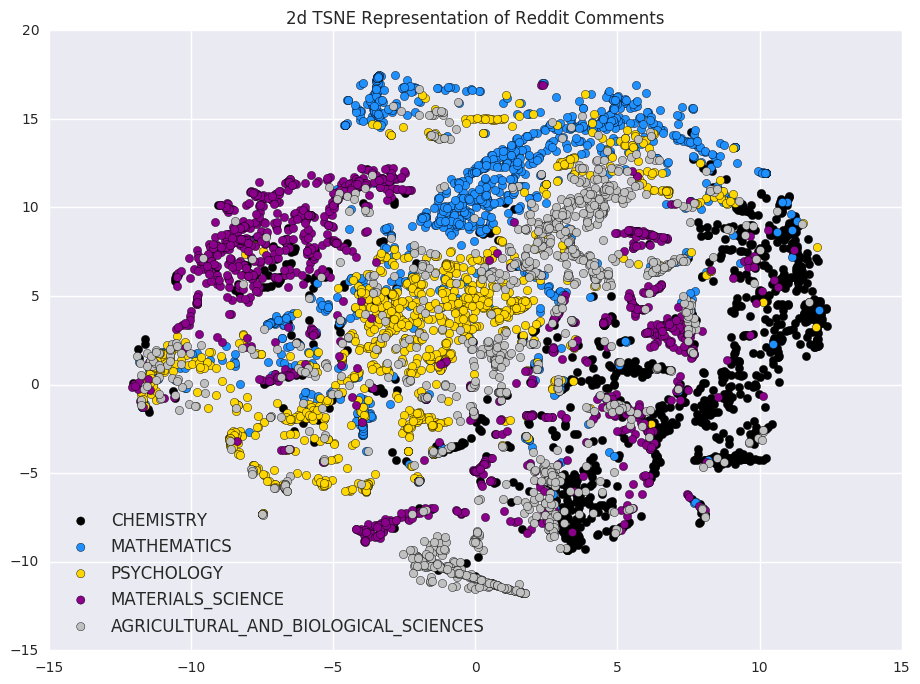

In [13]:
# Get a random subset of 6000 comments, 1200 each in Chemistry, Math, 
# Phych, Materials, and Biology
n_per_topic = 1200
topic_sub_list = ['CHEMISTRY_ALL','MATHEMATICS_ALL',\
                  'PSYCHOLOGY_ALL','MATERIALS_SCIENCE_ALL','AGRICULTURAL_AND_BIOLOGICAL_SCIENCES_ALL']
n_topic = len (topic_sub_list)

# xform_sub is the subset of the data... it started empty in the 0-dimension 
# and will grow through row concatenation with random comments from
# each topic
xform_sub = np.zeros ((0, n_dim))
y_sub = []


# Loop over topics
for t in topic_sub_list:
    df_one_topic = df_xform[df_xform.TOPIC == t]  # get subset of just desired topic
    
    # Choose a random list of indices in the topics of given subset
    idx_sub = np.random.choice (range (len (df_one_topic)), \
                            size = n_per_topic, replace = False)
    #now append to the xform_sub array
    #xform_sum = np.concatenate(xform_sub, df_one_topic.XFORM[idx_sub])
    #loop over the random indices
    
    for i in idx_sub:
        xform_sub = np.row_stack((xform_sub, df_one_topic.XFORM.iloc[i]))
    
    #append to the y_sub
    y_sub.extend ([t] * n_per_topic)
    
model_2d = TSNE (n_components = 2, perplexity = 30, random_state = 42)
comments_2d = model_2d.fit_transform (xform_sub)

x = comments_2d [:,0].tolist()
y = comments_2d [:,1].tolist()

fig = plt.figure(figsize = (11,8))
color_list = ['black', 'dodgerblue','gold','darkmagenta','silver']
s = []        
for i, c in enumerate (color_list):
    x_sub = x[(i*n_per_topic):(i+1)*(n_per_topic)]
    y_sub = y[(i*n_per_topic):(i+1)*(n_per_topic)]
    s.append (plt.scatter (x_sub, y_sub, c=c, s=35))                 
plt.legend(s,[i[0:-4] for i in topic_sub_list],\
           scatterpoints=1,loc='lower left',ncol=1,fontsize=12)
plt.title ('2d TSNE Representation of Reddit Comments')
plt.show()